In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from platypus import NSGAII, Problem, Real, Integer, SBX, PM, CompoundOperator

## Initialize reservoirs

In [52]:
from Reservoir4 import Reservoir

ice_harbor = Reservoir(SA=9200*4047,capacity=603000,tail_elev=339,pool_elev=446,bottom_elev=310,fish_pass=0.965, pc=106_000, spillway_cap=850_000, alfa=2.2, beta=4.9)
lower_monumental = Reservoir(SA=6590*4047,capacity=810000,tail_elev=439,pool_elev=548.3,bottom_elev=406,fish_pass=0.965, pc=130_000, spillway_cap=850_000, alfa=2.2, beta=4.9)
little_goose = Reservoir(SA=10025*4047,capacity=903000,tail_elev=539,pool_elev=646.5,bottom_elev=500,fish_pass=0.9775, pc=130_000, spillway_cap=850_000, alfa=2.2, beta=4.9)
lower_granite = Reservoir(SA=8900*4047,capacity=810000,tail_elev=636,pool_elev=746.5,bottom_elev=590,fish_pass=1, pc=130_000, spillway_cap=850_000, alfa=2.2, beta=4.9)

## Import data

In [53]:
# we only need lower granite inflow and tributary flow for each reservoir. Importing outflow data for comparison.
pre_cutoff = datetime(1970,1,1)
post_cutoff = datetime(1993,1,1)

# lower granite
lower_granite_data = pd.read_csv('lowergraniteinflow.csv')
lower_granite_outflows = pd.read_csv('lowergraniteoutflow.csv')
lower_granite_data = lower_granite_data.merge(lower_granite_outflows, how='inner', on=['date'])
lower_granite_data['date'] = pd.to_datetime(lower_granite_data['date'])
lower_granite_data['L (unit:cfs)'] = 0 #NO TRIB DATA FOR LOWER GRANITE
lower_granite_pre = lower_granite_data[lower_granite_data['date'] <= pre_cutoff]
lower_granite_post = lower_granite_data[lower_granite_data['date'] >= post_cutoff]

# little goose
little_goose_data = pd.read_csv('littlegooseoutflow.csv')               
little_goose_data['L (unit:cfs)'] = 0 #NO TRIB DATA FOR LITTLE GOOSE
little_goose_data['date'] = pd.to_datetime(little_goose_data['date'])
little_goose_pre = little_goose_data[little_goose_data['date'] <= pre_cutoff]
little_goose_post = little_goose_data[little_goose_data['date'] >= post_cutoff]

# lower monumental
lower_monumental_trib = pd.read_csv('lowermontrib.csv')
lower_monumental_outflows = pd.read_csv('lowermonumentaloutflow.csv')
lower_monumental_trib['L (unit:cfs)'] = lower_monumental_trib['L (unit:cfs)'].clip(lower=0)
lower_monumental_data = lower_monumental_trib.merge(lower_monumental_outflows, how='inner', on=['date'])
lower_monumental_data['date'] = pd.to_datetime(lower_monumental_data['date'])
lower_monumental_pre = lower_monumental_data[lower_monumental_data['date'] <= pre_cutoff]
lower_monumental_post = lower_monumental_data[lower_monumental_data['date'] >= post_cutoff]

# ice harbor
ice_harbor_outflow = pd.read_csv('iceharboroutflow.csv')
ice_harbor_trib = pd.read_csv('iceharbortrib.csv')
ice_harbor_outflows = pd.read_csv('iceharboroutflow.csv')
ice_harbor_trib['L (unit:cfs)'] = ice_harbor_trib['L (unit:cfs)'].clip(lower=0)
ice_harbor_data = ice_harbor_trib.merge(ice_harbor_outflows, how='inner', on=['date'])
ice_harbor_data['date'] = pd.to_datetime(ice_harbor_data['date'])
ice_harbor_pre = ice_harbor_data[ice_harbor_data['date'] <= pre_cutoff]
ice_harbor_post = ice_harbor_data[ice_harbor_data['date'] >= post_cutoff]

## Simulate reservoirs in series

In [54]:
# lower granite simulation post 1993
keep_LGR=1
initial_height_LGR = 670*0.3046
param_LGR = {'mef':50000*(0.3046**3), 'h1':710*0.3046, 'm':1000}
datetimes=lower_granite_post['date']
prev_out_LGR=lower_granite_post['A (unit:cfs)'].values*0.3046**3
tributary_LGR=lower_granite_post['L (unit:cfs)'].values*0.3046**3
    
LGR_outflow, LGR_hydro, LGR_height = lower_granite.simulate(keep_LGR, initial_height_LGR, param_LGR, datetime=datetimes, prev_out=prev_out_LGR, tributary=tributary_LGR)

# little goose simulation
keep_LGS=1
initial_height_LGS = 570*0.3046
param_LGS = {'mef':60000*(0.3046**3), 'h1':760*0.3046, 'm':1000}
datetimes=little_goose_post['date']
prev_out_LGS=LGR_outflow
tributary_LGS=little_goose_post['L (unit:cfs)'].values*0.3046**3

LGS_outflow, LGS_hydro, LGS_height = little_goose.simulate(keep_LGS, initial_height_LGS, param_LGS, datetime=datetimes, prev_out=prev_out_LGS, tributary=tributary_LGS)

# lower monumental simulation
keep_LMN=1
initial_height_LMN = 470*0.3046
param_LMN = {'mef':70000*(0.3046**3), 'h1':810*0.3046, 'm':1000}
datetimes=lower_monumental_post['date']
prev_out_LMN=LGS_outflow
tributary_LMN=lower_monumental_post['L (unit:cfs)'].values*0.3046**3

LMN_outflow, LMN_hydro, LMN_height = lower_monumental.simulate(keep_LMN, initial_height_LMN, param_LMN, datetime=datetimes, prev_out=prev_out_LMN, tributary=tributary_LMN)

# ice harbor simulation
keep_ICH=1
initial_height_ICH = 370*0.3046
param_ICH = {'mef':80000*(0.3046**3), 'h1':600*0.3046, 'm':1000}
datetimes=ice_harbor_post['date']
prev_out_ICH=LMN_outflow
tributary_ICH=ice_harbor_post['L (unit:cfs)'].values*0.3046**3  

ICH_outflow, ICH_hydro, ICH_height = ice_harbor.simulate(keep_ICH, initial_height_ICH, param_ICH, datetime=datetimes, prev_out=prev_out_ICH, tributary=tributary_ICH)

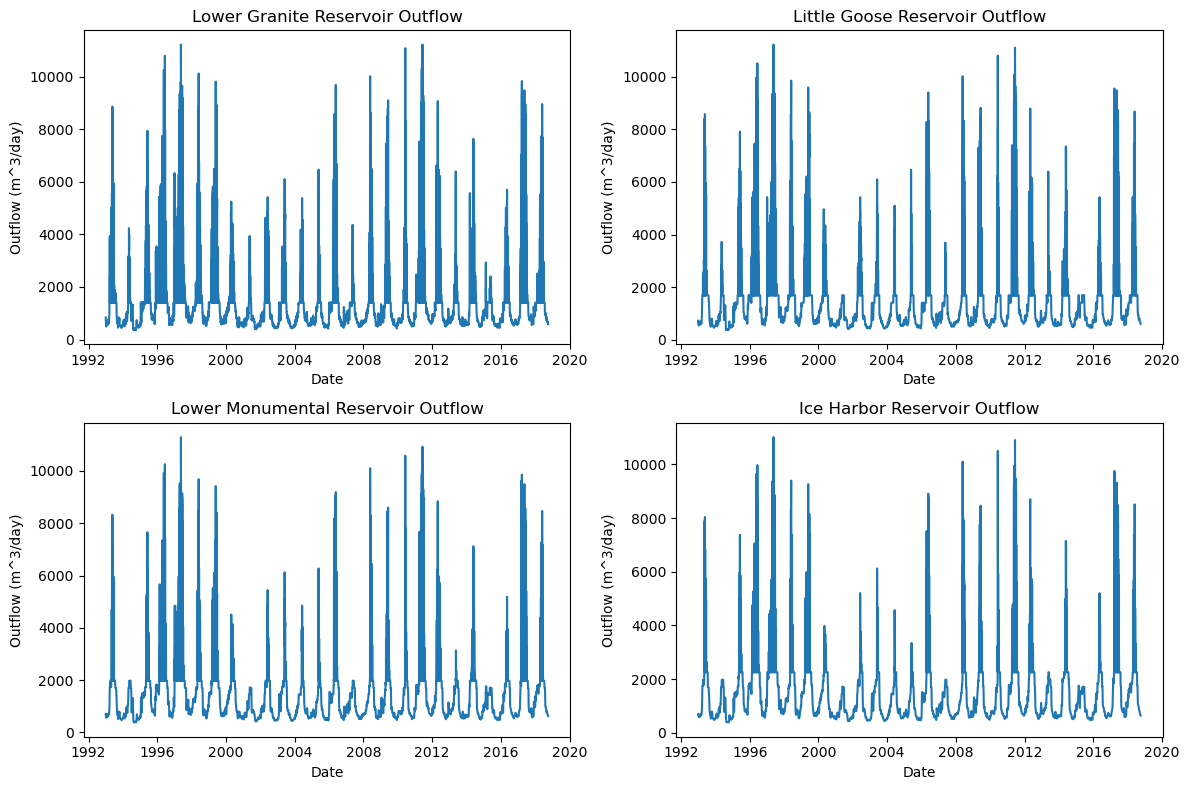

In [55]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(datetimes, LGR_outflow)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/day)')
plt.title('Lower Granite Reservoir Outflow')

plt.subplot(2,2,2)
plt.plot(datetimes, LGS_outflow)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/day)')
plt.title('Little Goose Reservoir Outflow')

plt.subplot(2,2,3)
plt.plot(datetimes, LMN_outflow)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/day)')
plt.title('Lower Monumental Reservoir Outflow')

plt.subplot(2,2,4)
plt.plot(datetimes, ICH_outflow)
plt.xlabel('Date')
plt.ylabel('Outflow (m^3/day)')
plt.title('Ice Harbor Reservoir Outflow')

plt.tight_layout()

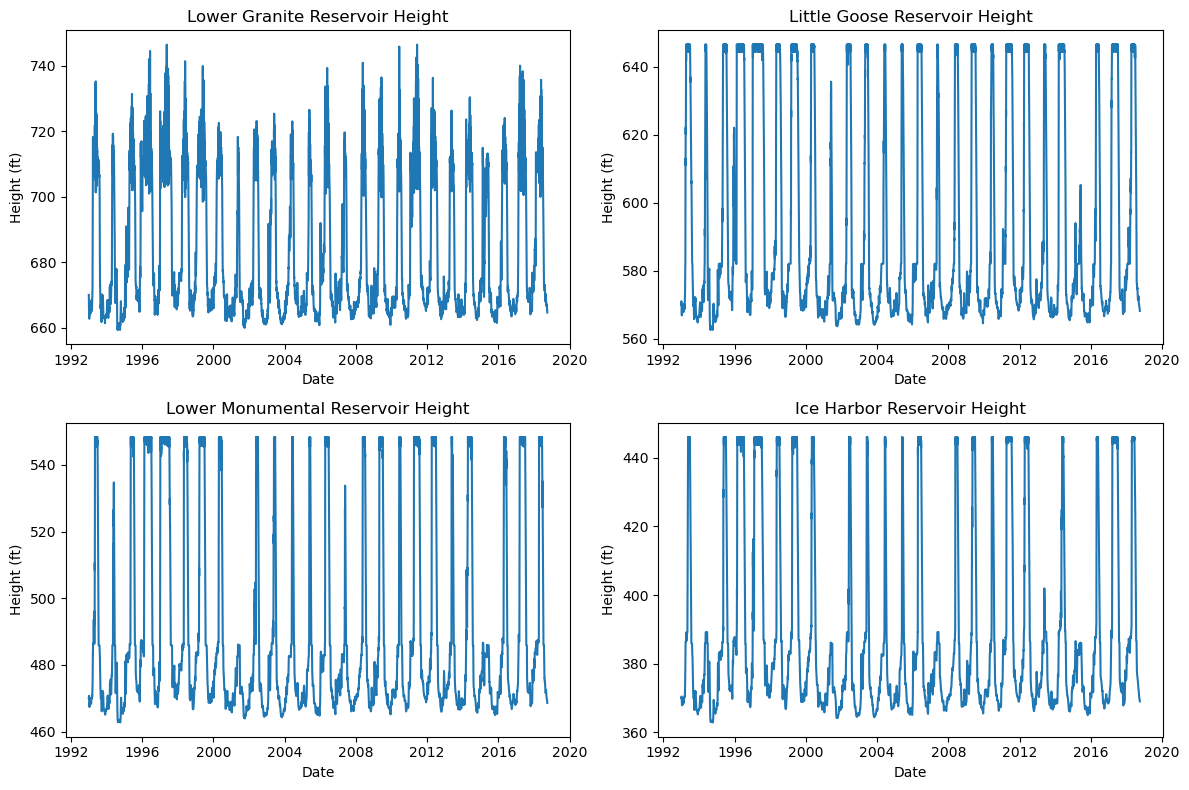

In [56]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(datetimes, LGR_height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Lower Granite Reservoir Height')

plt.subplot(2,2,2)
plt.plot(datetimes, LGS_height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Little Goose Reservoir Height')
    
plt.subplot(2,2,3)
plt.plot(datetimes, LMN_height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Lower Monumental Reservoir Height')

plt.subplot(2,2,4)
plt.plot(datetimes, ICH_height/0.3046)
plt.xlabel('Date')
plt.ylabel('Height (ft)')
plt.title('Ice Harbor Reservoir Height')

plt.tight_layout()

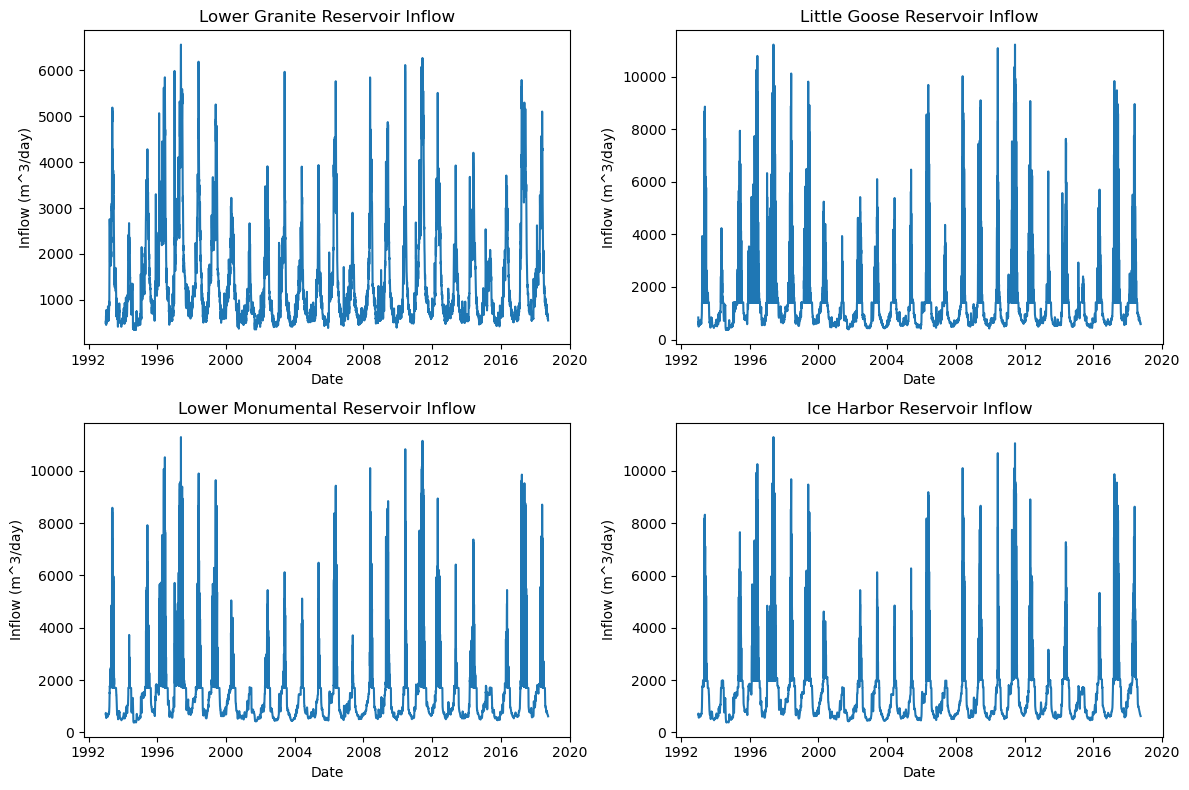

In [57]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(datetimes, prev_out_LGR + tributary_LGR)
plt.xlabel('Date')
plt.ylabel('Inflow (m^3/day)')
plt.title('Lower Granite Reservoir Inflow')

plt.subplot(2,2,2)
plt.plot(datetimes, prev_out_LGS + tributary_LGS)
plt.xlabel('Date')
plt.ylabel('Inflow (m^3/day)')
plt.title('Little Goose Reservoir Inflow')
    
plt.subplot(2,2,3)
plt.plot(datetimes, prev_out_LMN + tributary_LMN)
plt.xlabel('Date')
plt.ylabel('Inflow (m^3/day)')
plt.title('Lower Monumental Reservoir Inflow')

plt.subplot(2,2,4)
plt.plot(datetimes, prev_out_ICH + tributary_ICH)
plt.xlabel('Date')
plt.ylabel('Inflow (m^3/day)')
plt.title('Ice Harbor Reservoir Inflow')

plt.tight_layout()

## Calculate new objective function

In [58]:
# objective function: minimize number of years where minimum reservoir outflow is below historical minimum outflow median

hist_min_LGR = np.median(lower_granite_pre.groupby(lower_granite_pre['date'].dt.year)['H (unit:cfs)'].min()) * 0.3046**3
hist_min_LGS = np.median(little_goose_pre.groupby(little_goose_pre['date'].dt.year)['H (unit:cfs)'].min()) * 0.3046**3
hist_min_LMN = np.median(lower_monumental_pre.groupby(lower_monumental_pre['date'].dt.year)['H (unit:cfs)'].min()) * 0.3046**3
hist_min_ICH = np.median(ice_harbor_pre.groupby(ice_harbor_pre['date'].dt.year)['H (unit:cfs)'].min()) * 0.3046**3

def calculate_objective(LGR_outflow, LGS_outflow, LMN_outflow, ICH_outflow, datetimes):
    df = pd.DataFrame({'date': datetimes,
                       'LGR_outflow': LGR_outflow,
                       'LGS_outflow': LGS_outflow,
                       'LMN_outflow': LMN_outflow,
                       'ICH_outflow': ICH_outflow})
    df['year'] = df['date'].dt.year

    obj_LGR = df.groupby('year')['LGR_outflow'].min().lt(hist_min_LGR).sum()
    obj_LGS = df.groupby('year')['LGS_outflow'].min().lt(hist_min_LGS).sum()
    obj_LMN = df.groupby('year')['LMN_outflow'].min().lt(hist_min_LMN).sum()
    obj_ICH = df.groupby('year')['ICH_outflow'].min().lt(hist_min_ICH).sum()

    total_objective = obj_LGR + obj_LGS + obj_LMN + obj_ICH
    return total_objective

num_below_min = calculate_objective(LGR_outflow, LGS_outflow, LMN_outflow, ICH_outflow, datetimes)
print(f'Objective function value: {num_below_min}')

Objective function value: 32


## Optimization time!!

In [ ]:
datetimes = lower_granite_post['date']
initial_height_LGR = 670*0.3046
initial_height_LGS = 570*0.3046
initial_height_LMN = 470*0.3046
initial_height_ICH = 370*0.3046
prev_out_LGR = lower_granite_post['A (unit:cfs)'].values*0.3046**3
tributary_LGR = lower_granite_post['L (unit:cfs)'].values*0.3046**3
tributary_LGS = little_goose_post['L (unit:cfs)'].values*0.3046**3
tributary_LMN = lower_monumental_post['L (unit:cfs)'].values*0.3046**3  
tributary_ICH = ice_harbor_post['L (unit:cfs)'].values*0.3046**3

def simulateallopt(params, keep):
    param_LGR = {'mef':params[0], 'h1':params[4], 'm':params[8]}
    param_LGS = {'mef':params[1], 'h1':params[5], 'm':params[9]}
    param_LMN = {'mef':params[2], 'h1':params[6], 'm':params[10]}
    param_ICH = {'mef':params[3], 'h1':params[7], 'm':params[11]}
    keep_LGR = keep[0]
    keep_LGS = keep[1]
    keep_LMN = keep[2]
    keep_ICH = keep[3]
    
    LGR_outflow, LGR_hydro, LGR_height = lower_granite.simulate(keep_LGR, initial_height_LGR, param_LGR, datetime=datetimes, prev_out=prev_out_LGR, tributary=tributary_LGR)
    LGS_outflow, LGS_hydro, LGS_height = little_goose.simulate(keep_LGS, initial_height_LGS, param_LGS, datetime=datetimes, prev_out=LGR_outflow, tributary=tributary_LGS)
    LMN_outflow, LMN_hydro, LMN_height = lower_monumental.simulate(keep_LMN, initial_height_LMN, param_LMN, datetime=datetimes, prev_out=LGS_outflow, tributary=tributary_LMN)
    ICH_outflow, ICH_hydro, ICH_height = ice_harbor.simulate(keep_ICH, initial_height_ICH, param_ICH, datetime=datetimes, prev_out=LMN_outflow, tributary=tributary_ICH)
    
    total_hydro = LGR_hydro + LGS_hydro + LMN_hydro + ICH_hydro
    num_below_min = calculate_objective(LGR_outflow, LGS_outflow, LMN_outflow, ICH_outflow, datetimes)

    return num_below_min, total_hydro

In [69]:
class DamOptimization(Problem):
    def __init__(self):
        # Create a problem with 16 decision variables and 2 objectives
        super(DamOptimization, self).__init__(16, 2)  # 16 decision variables, 2 objectives

        self.types[:] = (
                        [Real(0, 10_000*(0.3046**3))] * 4 + # MEF for all dams
                        [Real(636*0.3046, 746.5*0.3046)] + # h1 LGR
                        [Real(539*0.3046, 646.5*0.3046)] + # h1 LGS
                        [Real(439*0.3046, 548.3*0.3046)] + # h1 LMN
                        [Real(339*0.3046, 446.4*0.3046)] + # h1 ICH
                        [Real(500, 5000)] * 4 + # m for all dams
                        [Integer(0,1)] * 4 # keep
                        )

    def evaluate(self, solutions):
        # Check if a single solution is passed
        if not isinstance(solutions, list):
            solutions = [solutions]
        
        for s in solutions:
            # Simulate the lake with current parameters
            params = s.variables[:-4]
            keep = s.variables[-4:]
            
            # Run the simulation function (ensure this is defined)
            num_below_min, total_hydro = simulateallopt(params, keep)
            
            # Set the objectives for the solution
            s.objectives[:] = [num_below_min, -total_hydro]

# Create the problem instance
problem = DamOptimization()

# Set up and run the algorithm
population_size = 50  # Change this to your desired population size
num_generations = 50  # Change this to your desired number of generations
total_evaluations = population_size * num_generations # Calculate total evaluations based on population size and generations
variator = CompoundOperator(
    *[op for _ in range(16) for op in (SBX(), PM())]
)
algorithm = NSGAII(problem,population_size=population_size, variator=variator)
algorithm.run(total_evaluations)  # Run for total evaluations

/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:108: RuntimeWarning: invalid value encountered in scalar power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)
/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:108: RuntimeWarning: invalid value encountered in scalar power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)
/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:108: RuntimeWarning: invalid value encountered in scalar power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)
/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:108: RuntimeWarning: invalid value encountered in scalar power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)
/Users/clairewang/Documents/GitHub/columbia_river_model/Reservoir4.py:108: RuntimeWarning: invalid value encountered in scalar power
  natural_flow = np.where(h > h0, beta * (h - h0) ** alfa, 0)
/Users/clairewang/Documen

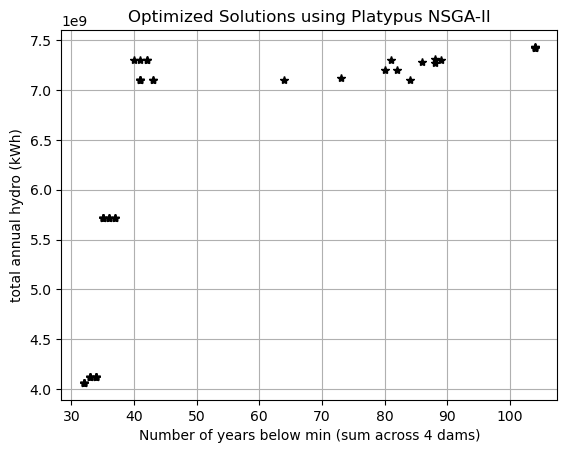

In [70]:
# Extract results for analysis
results = np.array([[s.objectives[0], -s.objectives[1]] for s in algorithm.result])

# Plot results
plt.figure()
plt.plot(results[:, 0], results[:, 1], 'k*')
plt.xlabel('Number of years below min (sum across 4 dams)')
plt.ylabel('total annual hydro (kWh)')
plt.title('Optimized Solutions using Platypus NSGA-II')
plt.grid(True)
plt.show()

## Run simulation with the best solution